In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import joblib
from tqdm import tqdm
import math

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, precision_recall_fscore_support

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torchinfo
from torch.utils.data import DataLoader, Dataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#import os
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [3]:
train_dataset = pd.read_json('/content/drive/My Drive/Colab Notebooks/Sentiment Analysis/dataset/train_data.jsonl')
val_dataset = pd.read_json('/content/drive/My Drive/Colab Notebooks/Sentiment Analysis/dataset/val_data.jsonl')
test_dataset = pd.read_json('/content/drive/My Drive/Colab Notebooks/Sentiment Analysis/dataset/test_data.jsonl')

In [6]:
X_train = train_dataset['text']
y_train = train_dataset['positive']
X_val = val_dataset['text']
y_val = val_dataset['positive']
X_test = test_dataset['text']
y_test = test_dataset['positive']

# Naive Bayes
- Combine title and content text data by concatenation

Compare two feature extracting methods.
1. CountVectorizer
2. TD-IDF

In [ ]:
X_train_nb = train_dataset['title'] + " " + train_dataset['text']
X_val_nb = val_dataset['title'] + " " + val_dataset['text']
X_test_nb = test_dataset['title'] + " " + test_dataset['text']

In [4]:
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr))
    roc_plot.plot()

In [ ]:
def train_clf(pipe, X_train, y_train, X_test, y_test):
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred)).plot()
    plot_roc_curve(y_test, y_pred)

Accuracy: 91.98%
              precision    recall  f1-score   support

           0       0.70      0.63      0.66     25695
           1       0.95      0.96      0.95    180163

    accuracy                           0.92    205858
   macro avg       0.82      0.79      0.81    205858
weighted avg       0.92      0.92      0.92    205858



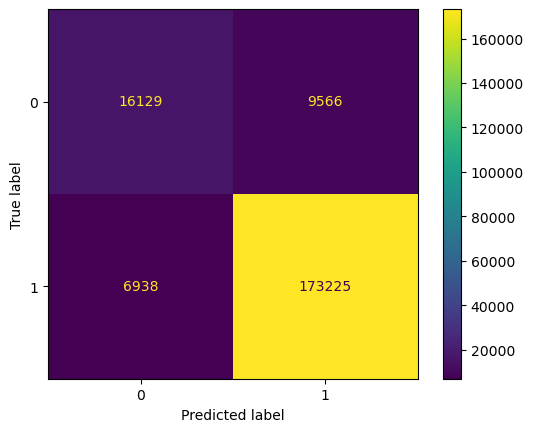

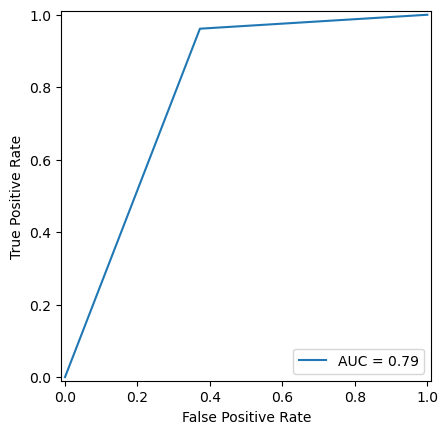

In [ ]:
cnt_pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB(alpha=1.0)),
])
train_clf(cnt_pipe, X_train_nb, y_train, X_test_nb, y_test)

Accuracy: 88.19%
              precision    recall  f1-score   support

           0       0.95      0.06      0.11     25695
           1       0.88      1.00      0.94    180163

    accuracy                           0.88    205858
   macro avg       0.92      0.53      0.52    205858
weighted avg       0.89      0.88      0.83    205858



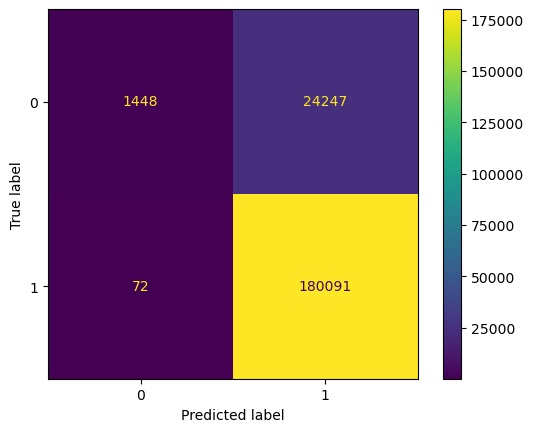

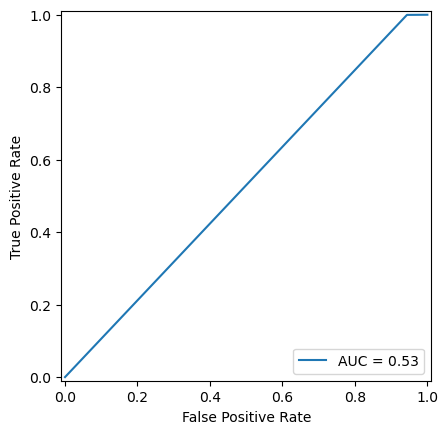

In [ ]:
tf_pipe = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', MultinomialNB(alpha=1.0)),
])
train_clf(tf_pipe, X_train, y_train, X_test, y_test)

Experiment ngram_range=(1,2)

Accuracy: 91.02%
              precision    recall  f1-score   support

           0       0.94      0.30      0.46     25695
           1       0.91      1.00      0.95    180163

    accuracy                           0.91    205858
   macro avg       0.92      0.65      0.70    205858
weighted avg       0.91      0.91      0.89    205858



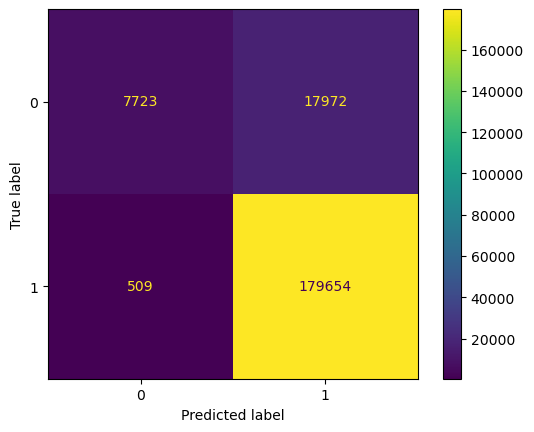

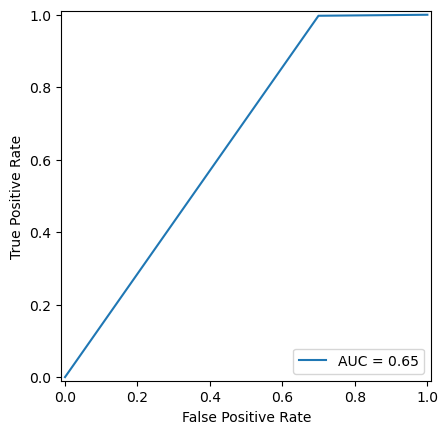

In [ ]:
gram2_pipe = Pipeline([
    ('vect', CountVectorizer(ngram_range=(2,2))),
    ('clf', MultinomialNB(alpha=1.0)),
])
train_clf(gram2_pipe, X_train_nb, y_train, X_test_nb, y_test)

Accuracy: 90.03%
              precision    recall  f1-score   support

           0       0.97      0.21      0.34     25695
           1       0.90      1.00      0.95    180163

    accuracy                           0.90    205858
   macro avg       0.93      0.60      0.64    205858
weighted avg       0.91      0.90      0.87    205858



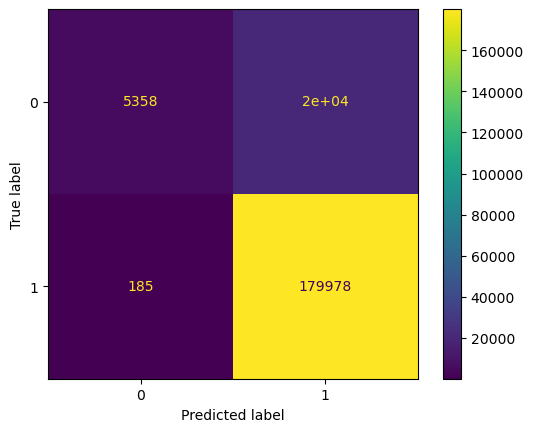

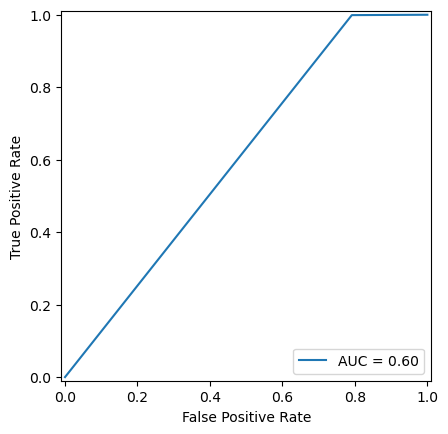

In [ ]:
gram12_pipe = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2))),
    ('clf', MultinomialNB(alpha=1.0)),
])
train_clf(gram12_pipe, X_train_nb, y_train, X_test_nb, y_test)

In [ ]:
joblib.dump(cnt_pipe, './weight/nb_best.pkl')

['./weight/nb_best.pkl']

# RNN
- Create two parallel LSTM branches—one for review text, one for title text—and then concatenate their final hidden states.

<Axes: >

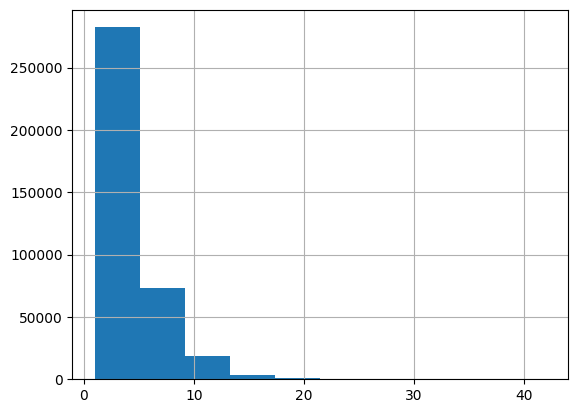

In [ ]:
review_length = train_dataset['title_tokenized'].map(lambda x: len(x))
review_length.hist()

<Axes: >

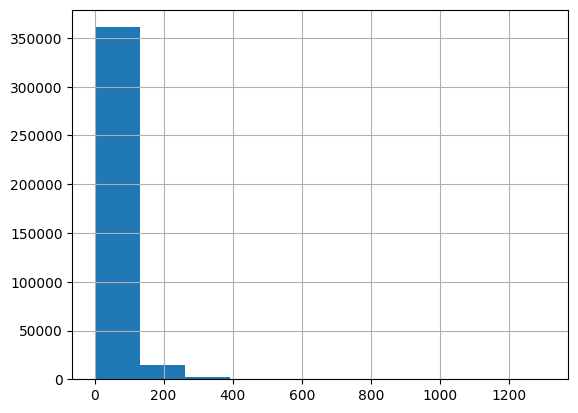

In [17]:
review_length = train_dataset['text_tokenized'].map(lambda x: len(x))
review_length.hist()

In [ ]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378952 entries, 0 to 378951
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   rating           378952 non-null  int64 
 1   title            378952 non-null  object
 2   text             378952 non-null  object
 3   helpful_vote     378952 non-null  int64 
 4   year             378952 non-null  int64 
 5   category         378952 non-null  object
 6   text_tokenized   378952 non-null  object
 7   title_tokenized  378952 non-null  object
 8   positive         378952 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 26.0+ MB


In [ ]:
class Vocab:
    def __init__(self, token_lists, min_freq=1):
        freq = {}
        for token in token_lists:
            for t in token:
                freq[t] = freq.get(t, 0) + 1
        self.itos = ['<PAD>', '<UNK>'] + [t for t,f in freq.items() if f >= min_freq]
        self.stoi = {t:i for i,t in enumerate(self.itos)}
    def encode(self, tokens):
        return [self.stoi.get(t, self.stoi['<UNK>']) for t in tokens]


In [19]:
all_token_lists = train_dataset['title_tokenized'].tolist() + train_dataset['text_tokenized'].tolist()
vocab = Vocab(all_token_lists, min_freq=2)

In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, df, vocab):
        self.title_seqs = [torch.tensor(vocab.encode(toks), dtype=torch.long) for toks in df['title_tokenized']]
        self.text_seqs = [torch.tensor(vocab.encode(toks), dtype=torch.long) for toks in df['text_tokenized']]
        self.labels = torch.tensor(df['positive'].values, dtype=torch.float)

    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.title_seqs[idx], self.text_seqs[idx], self.labels[idx]

In [ ]:
X_train_rnn = ReviewDataset(train_dataset, vocab)
X_val_rnn = ReviewDataset(val_dataset, vocab)
X_test_rnn = ReviewDataset(test_dataset, vocab)

In [ ]:
def collate_fn(batch):
    titles, texts, labels = zip(*batch)

    title_lens = torch.tensor([t.size(0) for t in titles], dtype=torch.long)
    text_lens  = torch.tensor([t.size(0) for t in texts],  dtype=torch.long)

    padded_titles = pad_sequence(titles, batch_first=True, padding_value=vocab.stoi['<PAD>'])
    padded_texts  = pad_sequence(texts,  batch_first=True, padding_value=vocab.stoi['<PAD>'])

    return padded_titles, title_lens, padded_texts, text_lens, torch.stack(labels)

In [ ]:
train_loader_rnn = DataLoader(X_train_rnn, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader_rnn = DataLoader(X_val_rnn, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader_rnn = DataLoader(X_test_rnn, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [ ]:
class DualLSTMClassifier(nn.Module):
    def __init__(self,
                 vocab_size,
                 embed_dim=100,
                 hidden_dim=128,
                 num_layers=1,
                 bidirectional=True,
                 dropout=0.2):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.title_lstm = nn.LSTM(embed_dim,
                                  hidden_dim,
                                  num_layers=num_layers,
                                  bidirectional=bidirectional,
                                  batch_first=True)

        self.text_lstm  = nn.LSTM(embed_dim,
                                  hidden_dim,
                                  num_layers=num_layers,
                                  bidirectional=bidirectional,
                                  batch_first=True)

        factor = 2 if bidirectional else 1
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_dim*factor*2, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def forward(self,
                title_seq, title_len,
                text_seq,  text_len):
        title_emb = self.embedding(title_seq)
        text_emb  = self.embedding(text_seq)

        packed_title = pack_padded_sequence(title_emb,
                                            title_len.cpu(),
                                            batch_first=True,
                                            enforce_sorted=False)
        packed_text  = pack_padded_sequence(text_emb,
                                            text_len.cpu(),
                                            batch_first=True,
                                            enforce_sorted=False)

        _, (t, _) = self.title_lstm(packed_title)
        _, (x, _) = self.text_lstm(packed_text)


        if self.title_lstm.bidirectional:
            t_final = torch.cat([t[-2], t[-1]], dim=1)
            x_final = torch.cat([x[-2], x[-1]], dim=1)
        else:
            t_final = t[-1]
            x_final = x[-1]

        h = torch.cat([t_final, x_final], dim=1)

        logits = self.classifier(h).squeeze(1)
        return logits


In [18]:
def train_lstm(model, train_loader, val_loader, epochs, optimizer, criterion, device, best_model_path=None, scheduler=None, early_stopping=False):
    model.to(device)
    training_details = {}

    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []

    lr_reduction = 0
    best_val_accuracy = 0

    for epoch in range(epochs):
        print("\n\n********************************************")
        print(f"Epoch: {epoch + 1}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']}")

        # Training
        model.train()
        running_train_loss = 0.0
        correct_pred = 0
        total_pred = 0

        for i, (title_seq, title_lens, text_seq, text_lens, labels) in tqdm(enumerate(train_loader), total=len(train_loader), desc="Training"):
            title_seq = title_seq.to(device)
            title_lens = title_lens.to(device)
            text_seq = text_seq.to(device)
            text_lens  = text_lens.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(title_seq, title_lens, text_seq, text_lens)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).float()
            correct_pred += (preds == labels).sum().item()
            total_pred += labels.size(0)

        avg_train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_pred / total_pred
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(train_accuracy)
        print(f"Epoch {epoch}: Training Loss = {avg_train_loss:.4f} Training Accuracy = {train_accuracy:.4f}")

        # Validation
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for title_seq, title_lens, text_seq, text_lens, labels in tqdm(val_loader, total=len(val_loader), desc="Validation"):
                title_seq = title_seq.to(device)
                title_lens = title_lens.to(device)
                text_seq = text_seq.to(device)
                text_lens  = text_lens.to(device)

                labels = labels.to(device)
                outputs = model(title_seq, title_lens, text_seq, text_lens)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                probs = torch.sigmoid(outputs)
                preds = (probs >= 0.5).float()
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(val_accuracy)
        print(f"         Validation Loss = {avg_train_loss:.4f} Validation Accuracy = {val_accuracy:.4f}")

        if best_model_path is not None and val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved at epoch {epoch+1} with validation accuracy {val_accuracy:.4f}")

        if scheduler is not None:
            prev_lr = optimizer.param_groups[0]['lr']
            scheduler.step(val_accuracy)
            current_lr = optimizer.param_groups[0]['lr']
            if current_lr < prev_lr:
                lr_reduction += 1

        if scheduler is not None and early_stopping is True and lr_reduction >= 3:
            print("Early Stopping: Stop training because the learning rate has decreased 3 times.")
            break

    training_details["train_loss"] = train_loss_list
    training_details["val_loss"] = val_loss_list
    training_details["train_acc"] = train_acc_list
    training_details["val_acc"] = val_acc_list

    return training_details

In [ ]:
model = DualLSTMClassifier(len(vocab.itos), embed_dim=100, hidden_dim=128, bidirectional=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=1)
best_model_path="/content/drive/My Drive/Colab Notebooks/Sentiment Analysis/weights/lstm_base.pt"

In [ ]:
training_details = train_lstm(model,
                         train_loader=train_loader_rnn,
                         val_loader=val_loader_rnn,
                         epochs=50,
                         optimizer=optimizer,
                         criterion=criterion,
                         device=device,
                         early_stopping=True,
                         scheduler=scheduler,
                         best_model_path=best_model_path)



********************************************
Epoch: 1
Learning Rate: 0.001


Training: 100%|██████████| 5922/5922 [03:11<00:00, 30.93it/s]


Epoch 0: Training Loss = 0.1468 Training Accuracy = 0.9437


Validation: 100%|██████████| 1481/1481 [00:14<00:00, 100.48it/s]


        Validation Loss = 0.1468 Validation Accuracy = 0.9555
New best model saved at epoch 1 with validation accuracy 0.9555


********************************************
Epoch: 2
Learning Rate: 0.001


Training: 100%|██████████| 5922/5922 [03:11<00:00, 30.93it/s]


Epoch 1: Training Loss = 0.0952 Training Accuracy = 0.9644


Validation: 100%|██████████| 1481/1481 [00:14<00:00, 101.67it/s]


        Validation Loss = 0.0952 Validation Accuracy = 0.9575
New best model saved at epoch 2 with validation accuracy 0.9575


********************************************
Epoch: 3
Learning Rate: 0.001


Training: 100%|██████████| 5922/5922 [03:11<00:00, 30.95it/s]


Epoch 2: Training Loss = 0.0684 Training Accuracy = 0.9748


Validation: 100%|██████████| 1481/1481 [00:14<00:00, 101.89it/s]


        Validation Loss = 0.0684 Validation Accuracy = 0.9581
New best model saved at epoch 3 with validation accuracy 0.9581


********************************************
Epoch: 4
Learning Rate: 0.001


Training: 100%|██████████| 5922/5922 [03:11<00:00, 30.93it/s]


Epoch 3: Training Loss = 0.0453 Training Accuracy = 0.9839


Validation: 100%|██████████| 1481/1481 [00:14<00:00, 102.33it/s]


        Validation Loss = 0.0453 Validation Accuracy = 0.9531


********************************************
Epoch: 5
Learning Rate: 0.001


Training: 100%|██████████| 5922/5922 [03:10<00:00, 31.08it/s]


Epoch 4: Training Loss = 0.0290 Training Accuracy = 0.9896


Validation: 100%|██████████| 1481/1481 [00:14<00:00, 101.42it/s]


        Validation Loss = 0.0290 Validation Accuracy = 0.9564


********************************************
Epoch: 6
Learning Rate: 0.0001


Training: 100%|██████████| 5922/5922 [03:09<00:00, 31.21it/s]


Epoch 5: Training Loss = 0.0126 Training Accuracy = 0.9957


Validation: 100%|██████████| 1481/1481 [00:14<00:00, 101.05it/s]


        Validation Loss = 0.0126 Validation Accuracy = 0.9579


********************************************
Epoch: 7
Learning Rate: 0.0001


Training: 100%|██████████| 5922/5922 [03:10<00:00, 31.08it/s]


Epoch 6: Training Loss = 0.0072 Training Accuracy = 0.9977


Validation: 100%|██████████| 1481/1481 [00:14<00:00, 101.91it/s]


        Validation Loss = 0.0072 Validation Accuracy = 0.9574


********************************************
Epoch: 8
Learning Rate: 1e-05


Training: 100%|██████████| 5922/5922 [03:10<00:00, 31.05it/s]


Epoch 7: Training Loss = 0.0049 Training Accuracy = 0.9986


Validation: 100%|██████████| 1481/1481 [00:14<00:00, 101.83it/s]


        Validation Loss = 0.0049 Validation Accuracy = 0.9576


********************************************
Epoch: 9
Learning Rate: 1e-05


Training: 100%|██████████| 5922/5922 [03:34<00:00, 27.55it/s]


Epoch 8: Training Loss = 0.0045 Training Accuracy = 0.9986


Validation: 100%|██████████| 1481/1481 [00:16<00:00, 90.81it/s]

        Validation Loss = 0.0045 Validation Accuracy = 0.9575
Early Stopping: Stop training because the learning rate has decreased 3 times.


In [40]:
def evaluate(model , test_loader , loss_function ):
    y_true = []
    y_pred = []
    curr_loss = 0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for title_seq, title_lens, text_seq, text_lens, labels in tqdm(test_loader, desc="Test", leave=False):
            title_seq = title_seq.to(device)
            title_lens = title_lens.to(device)
            text_seq = text_seq.to(device)
            text_lens  = text_lens.to(device)

            labels = labels.to(device)
            outputs = model(title_seq, title_lens, text_seq, text_lens)
            loss = criterion(outputs, labels)

            curr_loss += loss.item()
            total_test += labels.size(0)
            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).float()
            correct_test += (preds == labels).sum().item()
            y_pred.extend(list(preds.cpu().numpy()))
            y_true.extend(list(labels.cpu().numpy()))

        test_loss = curr_loss / len(test_loader)
        test_accuracy = correct_test / total_test

    print(f"Test Accuracy: {test_accuracy:.4f} Loss : {test_loss:.4f}")
    print(classification_report(y_true, y_pred))
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred)).plot()
    plot_roc_curve(y_true, y_pred)

    return {"test_acc": test_accuracy, "test_loss": test_loss}

Test Accuracy: 0.9505 Loss : 0.1408
              precision    recall  f1-score   support

           0       0.84      0.74      0.79     25695
           1       0.96      0.98      0.97    180163

    accuracy                           0.95    205858
   macro avg       0.90      0.86      0.88    205858
weighted avg       0.95      0.95      0.95    205858



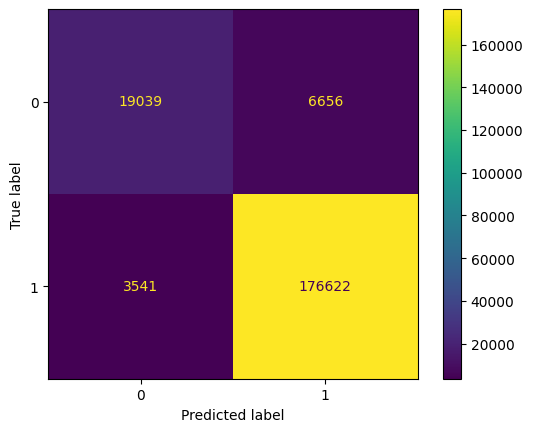

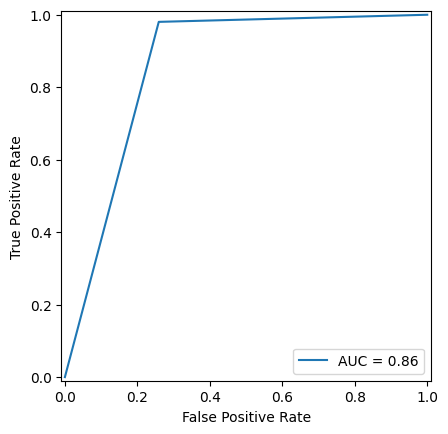

In [ ]:
model.load_state_dict(torch.load(best_model_path))
test_result_lstm_base  = evaluate(model , test_loader_rnn , criterion)

# Tramsformer
- concatenate title and text as "[CLS] title [SEP] text [SEP]"
- Custom nn.TransformerEncoder from Scratch

In [14]:
class ReviewDataset(Dataset):
    def __init__(self, df, vocab, max_len=200):
        self.data = []
        for _, row in df.iterrows():
            tokens = ["[CLS]"] + row['title_tokenized'] + ["[SEP]"] + row['text_tokenized'] + ["[SEP]"]
            ids = [vocab.stoi.get(t, vocab.stoi["<UNK>"]) for t in tokens]
            ids = ids[:max_len] + [vocab.stoi["<PAD>"]]*(max_len-len(ids))
            mask = [1 if i!=vocab.stoi["<PAD>"] else 0 for i in ids]
            self.data.append((torch.tensor(ids), torch.tensor(mask),
                              torch.tensor(row['positive'], dtype=torch.long)))
    def __len__(self): return len(self.data)
    def __getitem__(self, i): return self.data[i]

In [15]:
train_ds = ReviewDataset(train_dataset, vocab)
val_ds = ReviewDataset(val_dataset, vocab)
test_ds = ReviewDataset(test_dataset, vocab)

train_loader_tf = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader_tf = DataLoader(val_ds, batch_size=64)
test_loader_tf = DataLoader(test_ds, batch_size=64)

In [16]:
class PositionalEmbedding(nn.Module):
    def __init__(self, embed_model_dim, max_seq_len=200):
        super(PositionalEmbedding, self).__init__()
        self.d_model = embed_model_dim
        pe = torch.zeros(max_seq_len, self.d_model)
        for pos in range(max_seq_len):
            for k in range(self.d_model//2):
                freq = 10000 ** ((2 * k) / self.d_model)
                pe[pos, 2*k] = math.sin(pos / freq)
                pe[pos, 2*k + 1] = math.cos(pos / freq)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x: (batch, seq_len, d_model)
        return x + self.pe[:, :x.size(1), :].to(x.device)

In [30]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model=128, num_layers=2, nhead=8, num_classes=2):
        super(TransformerClassifier, self).__init__()
        self.embedding_layer = nn.Embedding(vocab_size, d_model, padding_idx=vocab.stoi["<PAD>"])
        self.pos = PositionalEmbedding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=512)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc_out = nn.Linear(d_model, num_classes)

    def forward(self, input_ids, attention_mask, mask=None):
        # x: (batch, seq_len)
        x = self.embedding_layer(input_ids)
        x = self.pos(x)
        x = x.transpose(0,1)

        key_padding_mask = attention_mask == 0
        out = self.encoder(x, src_key_padding_mask=key_padding_mask)
        logits = self.fc_out(out[0])
        return logits

In [ ]:
def train_tf(model, train_loader, val_loader, epochs, optimizer, criterion, device, best_model_path=None, scheduler=None, early_stopping=False):
    model.to(device)
    training_details = {}

    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []

    lr_reduction = 0
    best_val_accuracy = 0

    for epoch in range(epochs):
        print("\n\n********************************************")
        print(f"Epoch: {epoch + 1}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']}")

        # Training
        model.train()
        running_train_loss = 0.0
        correct_pred = 0
        total_pred = 0

        for i, (ids, mask, labels) in tqdm(enumerate(train_loader), total=len(train_loader), desc="Training"):
            ids, mask, labels = ids.to(device), mask.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(ids, mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            preds = outputs.argmax(dim=-1)
            correct_pred += (preds == labels).sum().item()
            total_pred += labels.size(0)

        avg_train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_pred / total_pred
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(train_accuracy)
        print(f"Epoch {epoch}: Training Loss = {avg_train_loss:.4f} Training Accuracy = {train_accuracy:.4f}")

        # Validation
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for ids, mask, labels in tqdm(val_loader, total=len(val_loader), desc="Validation"):
                ids, mask, labels = ids.to(device), mask.to(device), labels.to(device)
                outputs = model(ids, mask)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                preds = outputs.argmax(dim=-1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(val_accuracy)
        print(f"         Validation Loss = {avg_train_loss:.4f} Validation Accuracy = {val_accuracy:.4f}")

        if best_model_path is not None and val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved at epoch {epoch+1} with validation accuracy {val_accuracy:.4f}")

        if scheduler is not None:
            prev_lr = optimizer.param_groups[0]['lr']
            scheduler.step(val_accuracy)
            current_lr = optimizer.param_groups[0]['lr']
            if current_lr < prev_lr:
                lr_reduction += 1

        if scheduler is not None and early_stopping is True and lr_reduction >= 3:
            print("Early Stopping: Stop training because the learning rate has decreased 3 times.")
            break

    training_details["train_loss"] = train_loss_list
    training_details["val_loss"] = val_loss_list
    training_details["train_acc"] = train_acc_list
    training_details["val_acc"] = val_acc_list

    return training_details

In [39]:
model = TransformerClassifier(vocab_size=len(vocab.itos))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=1)
best_model_path="/content/drive/My Drive/Colab Notebooks/Sentiment Analysis/weights/transformer_base.pt"

training_details_base = train_tf(model=model,
                              train_loader=train_loader_tf,
                              val_loader=val_loader_tf,
                              epochs=15,
                              optimizer=optimizer,
                              criterion=criterion,
                              device=device,
                              early_stopping=True,
                              scheduler=scheduler,
                              best_model_path=best_model_path)



********************************************
Epoch: 1
Learning Rate: 0.001


Training: 100%|██████████| 5922/5922 [03:58<00:00, 24.79it/s]


Epoch 0: Training Loss = 0.1701 Training Accuracy = 0.9339


Validation: 100%|██████████| 1481/1481 [00:13<00:00, 107.00it/s]


         Validation Loss = 0.1701 Validation Accuracy = 0.9460
New best model saved at epoch 1 with validation accuracy 0.9460


********************************************
Epoch: 2
Learning Rate: 0.001


Training: 100%|██████████| 5922/5922 [03:58<00:00, 24.79it/s]


Epoch 1: Training Loss = 0.1293 Training Accuracy = 0.9502


Validation: 100%|██████████| 1481/1481 [00:13<00:00, 106.80it/s]


         Validation Loss = 0.1293 Validation Accuracy = 0.9492
New best model saved at epoch 2 with validation accuracy 0.9492


********************************************
Epoch: 3
Learning Rate: 0.001


Training: 100%|██████████| 5922/5922 [03:58<00:00, 24.80it/s]


Epoch 2: Training Loss = 0.1116 Training Accuracy = 0.9576


Validation: 100%|██████████| 1481/1481 [00:13<00:00, 107.43it/s]


         Validation Loss = 0.1116 Validation Accuracy = 0.9516
New best model saved at epoch 3 with validation accuracy 0.9516


********************************************
Epoch: 4
Learning Rate: 0.001


Training: 100%|██████████| 5922/5922 [03:58<00:00, 24.87it/s]


Epoch 3: Training Loss = 0.0974 Training Accuracy = 0.9632


Validation: 100%|██████████| 1481/1481 [00:13<00:00, 106.83it/s]


         Validation Loss = 0.0974 Validation Accuracy = 0.9526
New best model saved at epoch 4 with validation accuracy 0.9526


********************************************
Epoch: 5
Learning Rate: 0.001


Training: 100%|██████████| 5922/5922 [04:01<00:00, 24.54it/s]


Epoch 4: Training Loss = 0.0845 Training Accuracy = 0.9687


Validation: 100%|██████████| 1481/1481 [00:13<00:00, 106.55it/s]


         Validation Loss = 0.0845 Validation Accuracy = 0.9516


********************************************
Epoch: 6
Learning Rate: 0.001


Training: 100%|██████████| 5922/5922 [04:01<00:00, 24.54it/s]


Epoch 5: Training Loss = 0.0721 Training Accuracy = 0.9739


Validation: 100%|██████████| 1481/1481 [00:15<00:00, 96.85it/s]


         Validation Loss = 0.0721 Validation Accuracy = 0.9481


********************************************
Epoch: 7
Learning Rate: 0.0001


Training: 100%|██████████| 5922/5922 [03:59<00:00, 24.71it/s]


Epoch 6: Training Loss = 0.0469 Training Accuracy = 0.9839


Validation: 100%|██████████| 1481/1481 [00:13<00:00, 107.18it/s]


         Validation Loss = 0.0469 Validation Accuracy = 0.9500


********************************************
Epoch: 8
Learning Rate: 0.0001


Training: 100%|██████████| 5922/5922 [04:00<00:00, 24.59it/s]


Epoch 7: Training Loss = 0.0408 Training Accuracy = 0.9862


Validation: 100%|██████████| 1481/1481 [00:13<00:00, 107.00it/s]


         Validation Loss = 0.0408 Validation Accuracy = 0.9505


********************************************
Epoch: 9
Learning Rate: 1e-05


Training: 100%|██████████| 5922/5922 [03:58<00:00, 24.88it/s]


Epoch 8: Training Loss = 0.0356 Training Accuracy = 0.9884


Validation: 100%|██████████| 1481/1481 [00:13<00:00, 106.74it/s]


         Validation Loss = 0.0356 Validation Accuracy = 0.9501


********************************************
Epoch: 10
Learning Rate: 1e-05


Training: 100%|██████████| 5922/5922 [04:02<00:00, 24.47it/s]


Epoch 9: Training Loss = 0.0351 Training Accuracy = 0.9885


Validation: 100%|██████████| 1481/1481 [00:13<00:00, 107.02it/s]

         Validation Loss = 0.0351 Validation Accuracy = 0.9499
Early Stopping: Stop training because the learning rate has decreased 3 times.


In [44]:
def evaluate_tf(model , test_loader , loss_function ):
    y_true = []
    y_pred = []
    curr_loss = 0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for ids, mask, labels in tqdm(test_loader, desc="Test", leave=False):
            ids, mask, labels = ids.to(device), mask.to(device), labels.to(device)
            outputs = model(ids, mask)
            loss = criterion(outputs, labels)

            curr_loss += loss.item()
            total_test += labels.size(0)
            #probs = torch.sigmoid(outputs)
            #preds = (probs >= 0.5).float()
            preds = outputs.argmax(dim=-1)
            correct_test += (preds == labels).sum().item()
            y_pred.extend(list(preds.cpu().numpy()))
            y_true.extend(list(labels.cpu().numpy()))

        test_loss = curr_loss / len(test_loader)
        test_accuracy = correct_test / total_test

    print(f"Test Accuracy: {test_accuracy:.4f} Loss : {test_loss:.4f}")
    print(classification_report(y_true, y_pred))
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred)).plot()
    plot_roc_curve(y_true, y_pred)

    return {"test_acc": test_accuracy, "test_loss": test_loss}

Test Accuracy: 0.9451 Loss : 0.1650
              precision    recall  f1-score   support

           0       0.83      0.70      0.76     25695
           1       0.96      0.98      0.97    180163

    accuracy                           0.95    205858
   macro avg       0.90      0.84      0.87    205858
weighted avg       0.94      0.95      0.94    205858



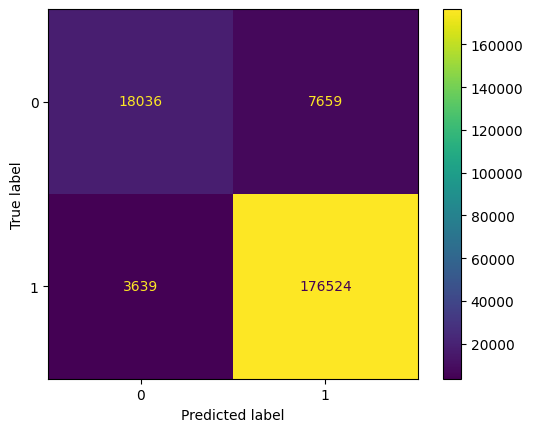

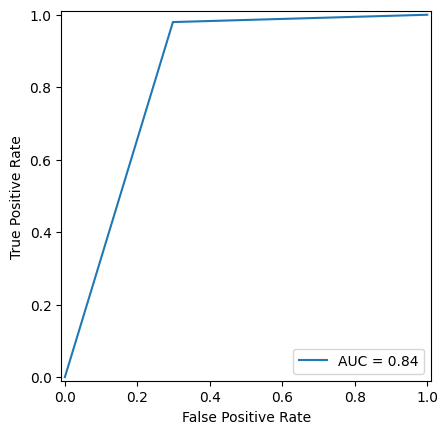

In [47]:
model.load_state_dict(torch.load(best_model_path))
test_result_tf_base  = evaluate_tf(model, test_loader_tf, criterion)

BERT

# References
- Deep Learning Assignment 1 by Heeju Hwang and Shubham Shubham
- Deep Learning Assignment 2 by Heeju Hwang and Sudheendra Peddiraju
- Data: https://amazon-reviews-2023.github.io/data_loading/jsonl.html
- https://www.kaggle.com/code/mehmetisik/amazon-reviews-boosting-sales-sentiment-analysis
- https://github.com/reasonmii/project-toxic-comment-classification/blob/main/Yuna-Supervised/Toxic-Classification.ipynb
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_text_feature_extraction.html
- https://www.kaggle.com/code/ankumagawa/sentimental-analysis-using-naive-bayes-classifier
- https://github.com/bentrevett/pytorch-sentiment-analysis/blob/main/2%20-%20Recurrent%20Neural%20Networks.ipynb
- https://suzyahyah.github.io/pytorch/2019/07/01/DataLoader-Pad-Pack-Sequence.html
- https://medium.com/geekculture/pytorch-datasets-dataloader-samplers-and-the-collat-fn-bbfc7c527cf1
- https://www.kaggle.com/code/arunmohan003/transformer-from-scratch-using-pytorch